# test_rating_classifiers

A notebook describing the rating classification.

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from scipy.stats import pearsonr
import pandas as pd
import connect_aws_db as cadb


In [2]:
%matplotlib inline

In [3]:
engine = cadb.connect_aws_db(write_unicode=True)

In [4]:
categories = ['dogs', 'general']

### Restore BF Reviews and Ratings

In [5]:
cmd = "SELECT review_rating, review_text FROM bf_reviews"

In [6]:
bfdf = pd.read_sql_query(cmd, engine)

In [7]:
print(len(bfdf))
bfdf.head(5)

3150


,review_rating,review_text
0,2,When you first go to your room you notice the ...
1,2,We were going to the Pre-Westminster event tha...
2,2,While the room was not the fanciest that one c...
3,1,I stayed at the Hotel Penn in Manhattan becaus...
4,5,We loved this hotel! The are very friendly and...


Now limit the reviews used in training to only reviews with more than 350 characters.

In [8]:
bfdfl = bfdf[bfdf['review_text'].str.len() > 350].copy()

In [9]:
len(bfdfl)

1215

### Create Training and Testing Data

In [10]:
train_data = bfdfl['review_text'].values[:750]

In [11]:
y_train = bfdfl['review_rating'].values[:750]

In [12]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print('vectorized in {:.2f} seconds.'.format(duration))
print(X_train.shape)

vectorized in 0.11 seconds.
(750, 5679)


In [13]:
test_data = bfdfl['review_text'].values[750:]

In [14]:
t0 = time()
X_test = vectorizer.transform(test_data)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 0.06 seconds.


In [15]:
feature_names = np.asarray(vectorizer.get_feature_names())

In [16]:
len(feature_names)

5679

In [17]:
feature_names[:5]

array([u'00', u'000', u'00am', u'00p', u'0400'], 
      dtype='<U15')

In [18]:
y_test = bfdfl['review_rating'].values[750:]

### Now Test Several Classifiers

In [19]:
def benchmark(clf, pos_label=None):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.f1_score(y_test, pred, pos_label=pos_label)
    print("f1-score:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

#         if opts.print_top10 and feature_names is not None:
#             print("top 10 keywords per class:")
#             for i, category in enumerate(categories):
#                 top10 = np.argsort(clf.coef_[i])[-10:]
#                 print(trim("%s: %s"
#                       % (category, " ".join(feature_names[top10]))))
        print()

#     if opts.print_report:
#         print("classification report:")
#         print(metrics.classification_report(y_test, pred,
#                                             target_names=categories))

#     if opts.print_cm:
#         print("confusion matrix:")
#         print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, pred

In [20]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=20), 'RandomForest')):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
train time: 0.018s
test time:  0.001s
f1-score:   0.475
dimensionality: 5679
density: 1.000000
()
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.021s
test time:  0.001s
f1-score:   0.480
dimensionality: 5679
density: 0.518119
()
()
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, fit_intercept=True, loss='hinge',
              n_iter=50, n_jobs=1, random_state=None, shuffle=True,
              

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.001s
f1-score:   0.501
dimensionality: 5679
density: 0.917415
()
()
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')
train time: 0.001s
test time:  0.031s
f1-score:   0.466
()
RandomForest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.120s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.006s
f1-score:   0.388
()


In [21]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))



L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0)
train time: 0.023s
test time:  0.000s
f1-score:   0.495
dimensionality: 5679
density: 1.000000
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.020s
test time:  0.000s
f1-score:   0.495
dimensionality: 5679
density: 0.810988
()
()
L1 penalty
________________________________________________________________________________
Training: 
Line

/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with mu


test time:  0.000s
f1-score:   0.483
dimensionality: 5679
density: 0.027927
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.080s
test time:  0.000s
f1-score:   0.458
dimensionality: 5679
density: 0.116323
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [22]:
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.092s
test time:  0.000s
f1-score:   0.490
dimensionality: 5679
density: 0.504138
()
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.003s
test time:  0.002s
f1-score:   0.532
()
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.002s
test time:  0.000s
f1-score:   0.481
dimensional

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

In [23]:
class L1LinearSVC(LinearSVC):

    def fit(self, X, y):
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        self.transformer_ = LinearSVC(penalty="l1",
                                      dual=False, tol=1e-3)
        X = self.transformer_.fit_transform(X, y)
        return LinearSVC.fit(self, X, y)

    def predict(self, X):
        X = self.transformer_.transform(X)
        return LinearSVC.predict(self, X)

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(L1LinearSVC()))


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
L1LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)
train time: 0.059s
test time:  0.003s
f1-score:   0.488
dimensionality: 561
density: 0.998574
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


### Plot Results

In [24]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(5)]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


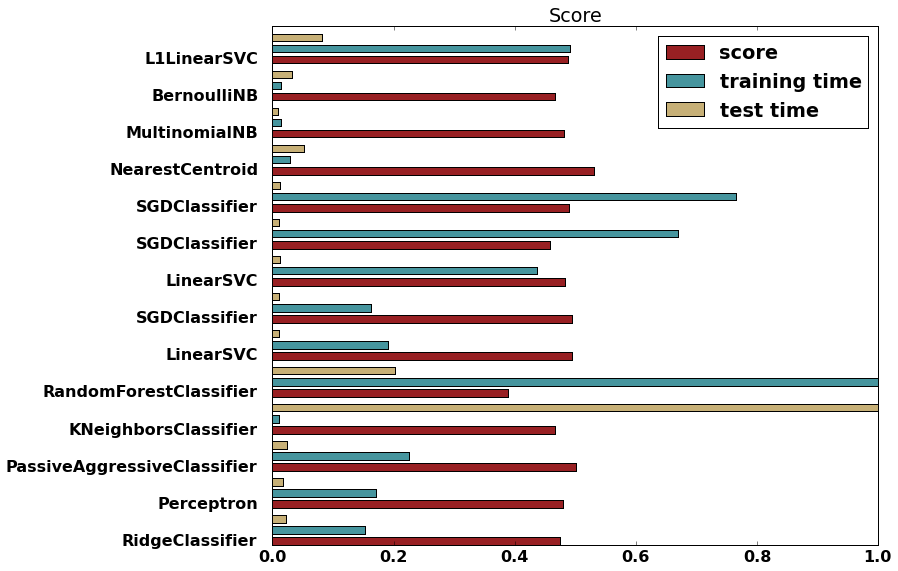

In [25]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12.94, 8
clf_names, score, training_time, test_time, pred = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

#plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='#982023')
plt.barh(indices + .3, training_time, .2, label="training time", color='#46959E')
plt.barh(indices + .6, test_time, .2, label="test time", color='#C7B077')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
plt.ylim(0, 14)
print(indices)
for i, c in zip(indices, clf_names):
    plt.text(-0.025, i, c, horizontalalignment='right')

In [26]:
clf_names[0] = 'Ridge'
clf_names[2] = 'PassAggress'
clf_names[3] = 'KNN'
clf_names[4] = 'RandomForest'
clf_names[5] = 'LinearSVC L2'
clf_names[6] = 'SGDC SVM L2'
clf_names[7] = 'LinearSVC L1'
clf_names[8] = 'SGDC L1'
clf_names[9] = 'SGDC ElNet'
clf_names[13] = 'LinearSVC L1FS'


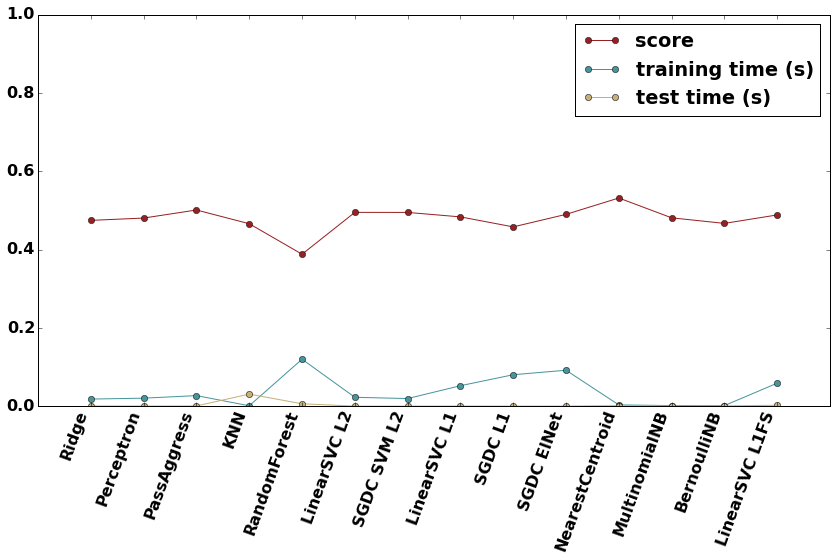

In [27]:
fig, ax = plt.subplots(1, 1)

clf_names, score, training_time, test_time, pred = results

ax.plot(indices, score, '-o', label="score", color='#982023')
ax.plot(indices, training_time, '-o', label="training time (s)", color='#46959E')
ax.plot(indices, test_time, '-o', label="test time (s)", color='#C7B077')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = clf_names
ax.xaxis.set_ticks(np.arange(np.min(indices), np.max(indices)+1, 1))
ax.set_xticklabels(clf_names, rotation='70', horizontalalignment='right')
ax.set_xlim([-1, 14])
ax.set_ylim([0, 1])
ax.legend(loc='best')
plt.subplots_adjust(left=0.05, bottom=0.3, top=.98)
plt.savefig('ratingClassifierScores.png', dpi=144)


In [28]:
for name, scr in zip(clf_names, score):
    print('{}: {:.3f}'.format(name, scr))

Ridge: 0.475
Perceptron: 0.480
PassAggress: 0.501
KNN: 0.466
RandomForest: 0.388
LinearSVC L2: 0.495
SGDC SVM L2: 0.495
LinearSVC L1: 0.483
SGDC L1: 0.458
SGDC ElNet: 0.490
NearestCentroid: 0.532
MultinomialNB: 0.481
BernoulliNB: 0.467
LinearSVC L1FS: 0.488


### Now Plot The Predicted Rating as a Function of the Given Rating for the BF Test Data

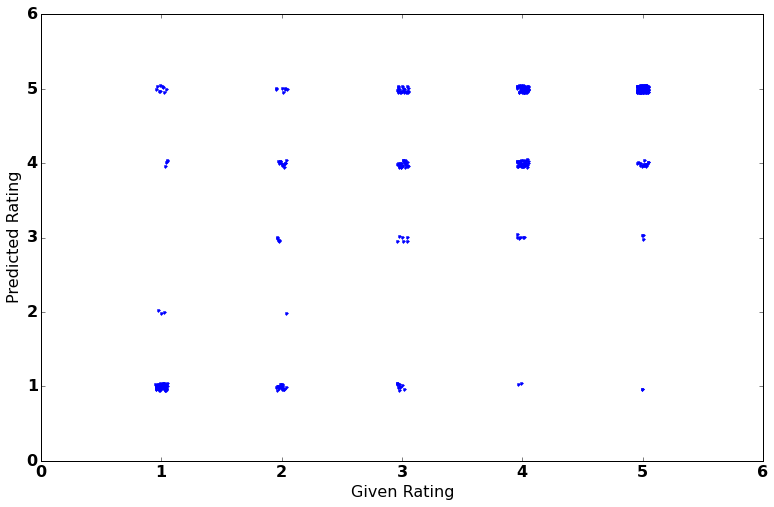

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(y_test + 0.1*np.random.random(len(y_test)) - 0.05, pred[0] + 0.1*np.random.random(len(y_test)) - 0.05, '.')
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_xlabel('Given Rating')
ax.set_ylabel('Predicted Rating')

In [30]:
ms = np.zeros((5, 5))
for row in range(5):
    for col in range(5):
        #print('row {}, col {}'.format(row, col))
        ms[row, col] = len(np.where((y_test == col+1) & (pred[0] == row+1))[0])
ms

array([[  66.,   21.,   10.,    2.,    2.],
       [   3.,    1.,    0.,    0.,    0.],
       [   0.,    5.,    6.,    6.,    3.],
       [   4.,   12.,   23.,   45.,   18.],
       [   9.,    7.,   24.,   68.,  130.]])

In [31]:
logms = 5*np.log(ms+1)
logms

array([[ 21.0234631 ,  15.45521227,  11.98947636,   5.49306144,
          5.49306144],
       [  6.93147181,   3.4657359 ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   8.95879735,   9.72955075,   9.72955075,
          6.93147181],
       [  8.04718956,  12.82474679,  15.89026915,  19.14320698,  14.7221949 ],
       [ 11.51292546,  10.39720771,  16.09437912,  21.17053252,
         24.37598662]])

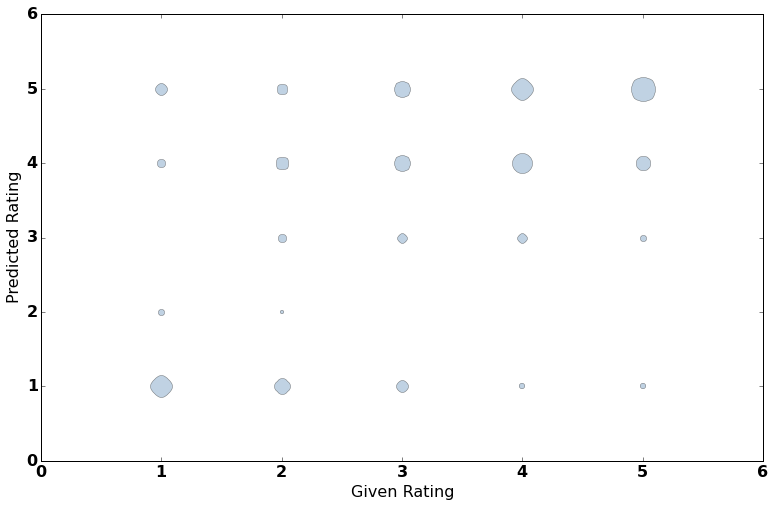

In [32]:
fig, ax = plt.subplots(1, 1)
for row in range(5):
    for col in range(5):
        ax.plot(col+1, row+1, 'o', ms=logms[row, col], color='#83A7C8', alpha=0.5)
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_xlabel('Given Rating')
ax.set_ylabel('Predicted Rating')
#plt.savefig('Predicted_Vs_Given_Bubbles.png', dpi=144)

In [33]:
for idx, prediction in enumerate(pred):
    print(idx, pearsonr(y_test, prediction))

(0, (0.73408561692323604, 7.4978233002237022e-80))
(1, (0.71795730664841839, 7.3315255884763415e-75))
(2, (0.74802472692495725, 1.8129647690238805e-84))
(3, (0.67694085709584473, 1.2939477654783603e-63))
(4, (0.61474595727021841, 1.1357868715657629e-49))
(5, (0.75596456481635421, 3.0935442129163404e-87))
(6, (0.71889254303619965, 3.8495983142824626e-75))
(7, (0.68715897311881469, 3.0540251940214587e-66))
(8, (0.68425784342385176, 1.7446846859279614e-65))
(9, (0.71920197982801881, 3.108818509785228e-75))
(10, (0.76890292060053278, 5.5499961727891711e-92))
(11, (0.76285209717199665, 1.0040308184358614e-89))
(12, (0.71860297233765302, 4.7007062272100025e-75))
(13, (0.7440387281205979, 4.0658705718232875e-83))


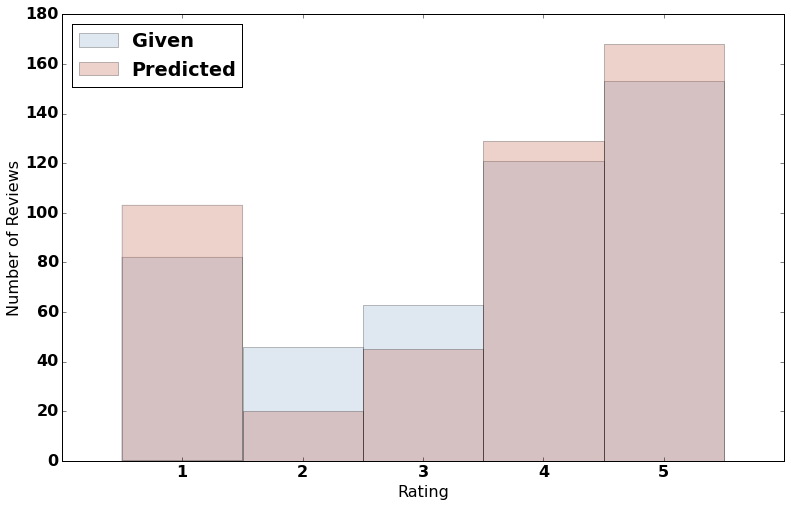

In [34]:
fig, ax = plt.subplots(1, 1)
ax.hist(y_test, bins=range(1, 7), align='left', color='#83A7C8', alpha=0.25, label='Given')
ax.hist(pred[10], bins=range(1, 7), align='left', color='#BA4C37', alpha=0.25, label='Predicted')
#ax.set_xlim([0, 6])
ax.xaxis.set_ticks([1, 2, 3, 4, 5])
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews')
ax.legend(loc='best')
#plt.savefig('PredictedGivenDist.png', dpi=144)

### confusion matrix

In [35]:
from sklearn import metrics

classification accuracy: 0.550537634409


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


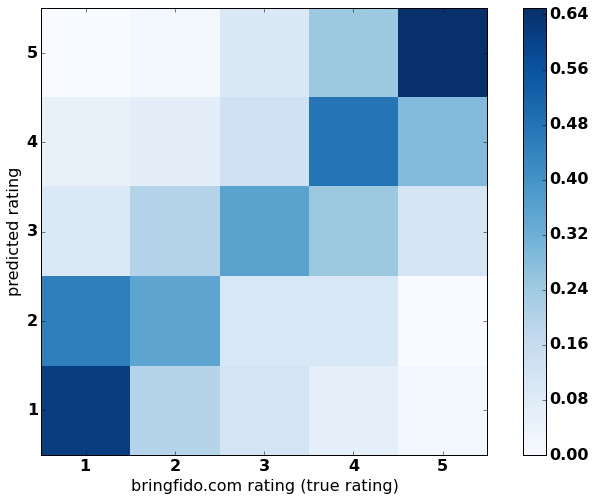

In [36]:
def plot_confusion_matrix(y_pred, y, normalize=False, cmap=plt.cm.binary):
    cm = metrics.confusion_matrix(y, y_pred)
    cm = np.flipud(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(0, 5), np.arange(1, 6))
    plt.yticks(np.arange(0, 5), np.arange(1, 6)[::-1])
    plt.xlabel('bringfido.com rating (true rating)')
    plt.ylabel('predicted rating')
    
print "classification accuracy:", metrics.accuracy_score(y_test, pred[10])
plot_confusion_matrix(y_test, pred[10], normalize=True, cmap=plt.cm.Blues)
#plt.savefig('rating_confusion_matrix.png', dpi=144)

In [39]:
clf = NearestCentroid()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [49]:
cens = clf.centroids_

In [42]:
clf.get_params()

{'metric': 'euclidean', 'shrink_threshold': None}

In [73]:
words = vectorizer.get_feature_names()
len(words)

5679

In [50]:
cens.shape

(5, 5679)

Which features/words have the highest weight towards rating 1?

#### Unnormalized centroid

In [146]:
wgtarr = cens[4,:]

In [153]:
ratwords = np.argsort(wgtarr).tolist()[::-1]

In [155]:
for i in range(20):
    print(wgtarr[ratwords[i]], words[ratwords[i]], ratwords[i])

(0.039678976367216699, u'friendly', 2129)
(0.038829214996624201, u'great', 2282)
(0.037077246202368269, u'dogs', 1623)
(0.036880570644430358, u'pet', 3692)
(0.036289851442712753, u'staff', 4779)
(0.034472449133846991, u'stay', 4820)
(0.02977112390032639, u'clean', 1071)
(0.026750827680018161, u'nice', 3383)
(0.026532648766232944, u'area', 415)
(0.025088203493955637, u'stayed', 4823)
(0.023759543575102824, u'rooms', 4291)
(0.022878835726488286, u'breakfast', 781)
(0.022008297630212798, u'walk', 5460)
(0.021970883190935833, u'definitely', 1467)
(0.0202998343833985, u'comfortable', 1148)
(0.019212745675466505, u'just', 2764)
(0.01855555687287249, u'walking', 5465)
(0.018298778225236477, u'wonderful', 5600)
(0.018208504773093756, u'park', 3605)
(0.018013170920323687, u'pets', 3697)


In [159]:
cens[:, 1148]

array([ 0.00294032,  0.00827302,  0.01106283,  0.02230172,  0.02029983])

#### Normalized centroid

First compute the total for each feature across all ratings (1 to 5)

In [105]:
cen_tot = np.sum(cens, axis=0)

In [106]:
cen_tot.shape

(5679,)

In [139]:
wgtarr = cens[4,:]/cen_tot

In [140]:
words[np.argsort(wgtarr)[0]]

u'lacks'

In [144]:
ratwords = np.argsort(wgtarr).tolist()[::-1]


In [145]:
for i in range(20):
    print(wgtarr[ratwords[i]], words[ratwords[i]])

(1.0, u'decision')
(1.0, u'departing')
(1.0, u'rittenhouse')
(1.0, u'rivals')
(1.0, u'desiree')
(1.0, u'riverwalk')
(1.0, u'roadhouse')
(1.0, u'deserves')
(1.0, u'described')
(1.0, u'derby')
(1.0, u'deposited')
(1.0, u'departure')
(1.0, u'rollaway')
(1.0, u'desserts')
(1.0, u'delux')
(1.0, u'rose')
(1.0, u'rottweilers')
(1.0, u'delishious')
(1.0, u'delegated')
(1.0, u'routine')


### Expanding the Model to 3-grams

In [209]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english', ngram_range=(1, 3))
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print('vectorized in {:.2f} seconds.'.format(duration))
print(X_train.shape)

vectorized in 0.70 seconds.
(750, 73002)


In [191]:
t0 = time()
X_test = vectorizer.transform(test_data)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 0.16 seconds.


In [192]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=20), 'RandomForest')):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
train time: 0.078s
test time:  0.002s
f1-score:   0.413
dimensionality: 73002
density: 1.000000
()
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.087s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.005s
f1-score:   0.467
dimensionality: 73002
density: 0.337969
()
()
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, fit_intercept=True, loss='hinge',
              n_iter=50, n_jobs=1, random_state=None, shuffle=True,
              verbose=0, warm_start=False)
train time: 0.111s
test time:  0.004s
f1-score:   0.466
dimensionality: 73002
density: 0.980822
()
()
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')
train time: 0.001s
test time:  0.040s
f1-score:   0.437
()
RandomForest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='a

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.010s
f1-score:   0.345
()


In [193]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0)
train time: 0.161s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)



test time:  0.001s
f1-score:   0.433
dimensionality: 73002
density: 1.000000
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.078s
test time:  0.002s
f1-score:   0.481
dimensionality: 73002
density: 0.899162
()
()
L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)
train time: 0.242s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with mu


test time:  0.001s
f1-score:   0.448
dimensionality: 73002
density: 0.000658
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.292s
test time:  0.004s
f1-score:   0.480
dimensionality: 73002
density: 0.041002
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [194]:
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.387s
test time:  0.005s
f1-score:   0.469
dimensionality: 73002
density: 0.331577
()
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.013s
test time:  0.008s
f1-score:   0.448
()
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.013s
test time:  0.002s
f1-score:   0.446
dimensiona

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.010s
test time:  0.015s
f1-score:   0.401
dimensionality: 73002
density: 1.000000
()
()


In [195]:
class L1LinearSVC(LinearSVC):

    def fit(self, X, y):
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        self.transformer_ = LinearSVC(penalty="l1",
                                      dual=False, tol=1e-3)
        X = self.transformer_.fit_transform(X, y)
        return LinearSVC.fit(self, X, y)

    def predict(self, X):
        X = self.transformer_.transform(X)
        return LinearSVC.predict(self, X)

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(L1LinearSVC()))


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
L1LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)
train time: 0.178s
test time:  0.005s
f1-score:   0.434
dimensionality: 187
density: 1.000000
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [196]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(5)]

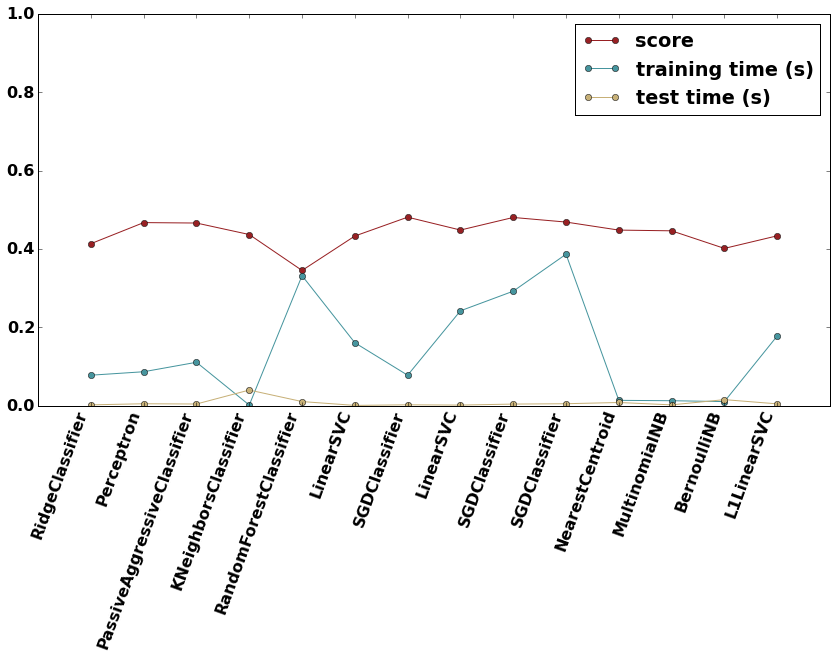

In [197]:
fig, ax = plt.subplots(1, 1)

clf_names, score, training_time, test_time, pred = results

ax.plot(indices, score, '-o', label="score", color='#982023')
ax.plot(indices, training_time, '-o', label="training time (s)", color='#46959E')
ax.plot(indices, test_time, '-o', label="test time (s)", color='#C7B077')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = clf_names
ax.xaxis.set_ticks(np.arange(np.min(indices), np.max(indices)+1, 1))
ax.set_xticklabels(clf_names, rotation='70', horizontalalignment='right')
ax.set_xlim([-1, 14])
ax.set_ylim([0, 1])
ax.legend(loc='best')
plt.subplots_adjust(left=0.05, bottom=0.3, top=.98)
#plt.savefig('ratingClassifierScores.png', dpi=144)

## Expanding the Model to 2-grams

In [198]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print('vectorized in {:.2f} seconds.'.format(duration))
print(X_train.shape)

vectorized in 0.36 seconds.
(750, 36091)


In [199]:
t0 = time()
X_test = vectorizer.transform(test_data)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 0.11 seconds.


In [203]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=20), 'RandomForest'),
        (LinearSVC(loss='l2', penalty="L2",dual=False, tol=1e-3), "LinearSVC L2"),
        (SGDClassifier(alpha=.0001, n_iter=50, penalty="L2"), "SGDC SVM L2"),
        (LinearSVC(loss='l2', penalty="L1",dual=False, tol=1e-3), "LinearSVC L1"),
        (SGDClassifier(alpha=.0001, n_iter=50, penalty="L1"), "SGDC SVM L1"),
        (SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet"), "Elastic Net"),
        (NearestCentroid(), "Nearest Centroid"),
        (MultinomialNB(alpha=.01), "MultinomialNB"),
        (BernoulliNB(alpha=.01), "BernouliNB")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
train time: 0.020s
test time:  0.002s
f1-score:   0.428
dimensionality: 36091
density: 1.000000
()
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.044s
test time:  0.001s
f1-score:   0.467
dimensionality: 36091
density: 0.364689
()
()
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, fit_intercept=True, loss='hinge',
              n_iter=50, n_jobs=1, random_state=None, shuffle=True,
            

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.001s
f1-score:   0.477
dimensionality: 36091
density: 0.953329
()
()
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')
train time: 0.001s
test time:  0.030s
f1-score:   0.444
()
RandomForest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.220s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.008s
f1-score:   0.384
()
LinearSVC L2
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='L2', random_state=None, tol=0.001, verbose=0)
train time: 0.071s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:798: DeprecationWarning: penalty='L2' has been deprecated in favor of penalty='l2' as of 0.16. Backward compatibility for the uppercase notation will be removed in 0.18
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring


test time:  0.001s
f1-score:   0.459
dimensionality: 36091
density: 1.000000
()
()
SGDC SVM L2
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='L2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.050s
test time:  0.003s
f1-score:   0.475
dimensionality: 36091
density: 0.859217
()
()
LinearSVC L1
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='L1', random_state=None, tol=0.001, verbose=0)
train time: 0.099s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:798: DeprecationWarning: penalty='L1' has been deprecated in favor of penalty='l1' as of 0.16. Backward compatibility for the uppercase notation will be 


test time:  0.001s
f1-score:   0.451
dimensionality: 36091
density: 0.002150
()
()
SGDC SVM L1
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='L1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.164s
test time:  0.002s
f1-score:   0.474
dimensionality: 36091
density: 0.045978
()
()
Elastic Net
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
trai

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.004s
f1-score:   0.478
dimensionality: 36091
density: 0.352104
()
()
Nearest Centroid
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.009s
test time:  0.005s
f1-score:   0.490
()
MultinomialNB
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.018s
test time:  0.003s
f1-score:   0.471
dimensionality: 36091
density: 1.000000
()
()
BernouliNB
________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.015s

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


test time:  0.013s
f1-score:   0.452
dimensionality: 36091
density: 1.000000
()
()


In [204]:
class L1LinearSVC(LinearSVC):

    def fit(self, X, y):
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        self.transformer_ = LinearSVC(penalty="l1",
                                      dual=False, tol=1e-3)
        X = self.transformer_.fit_transform(X, y)
        return LinearSVC.fit(self, X, y)

    def predict(self, X):
        X = self.transformer_.transform(X)
        return LinearSVC.predict(self, X)

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(L1LinearSVC()))


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
L1LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)
train time: 0.094s
test time:  0.004s
f1-score:   0.474
dimensionality: 292
density: 1.000000
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [205]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(5)]

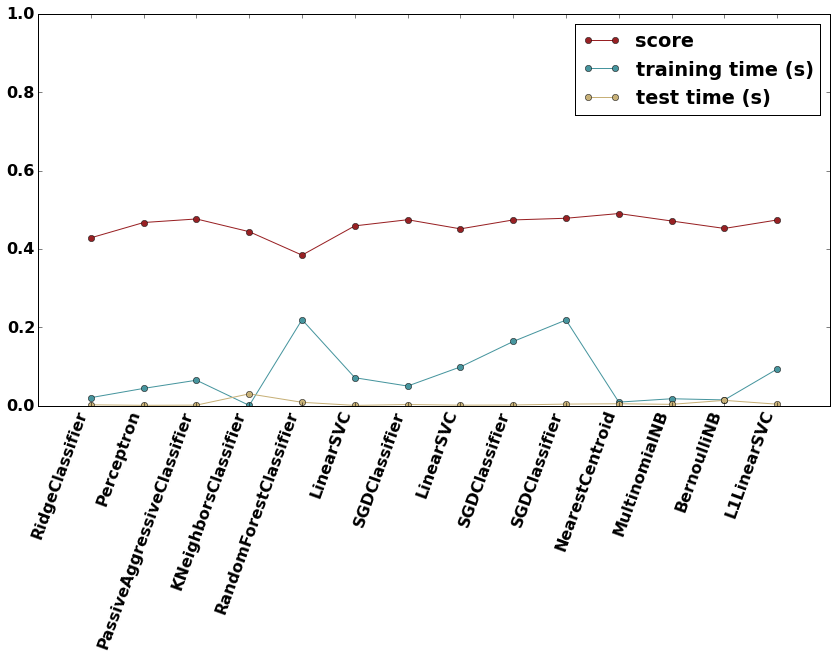

In [206]:
fig, ax = plt.subplots(1, 1)

clf_names, score, training_time, test_time, pred = results

ax.plot(indices, score, '-o', label="score", color='#982023')
ax.plot(indices, training_time, '-o', label="training time (s)", color='#46959E')
ax.plot(indices, test_time, '-o', label="test time (s)", color='#C7B077')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = clf_names
ax.xaxis.set_ticks(np.arange(np.min(indices), np.max(indices)+1, 1))
ax.set_xticklabels(clf_names, rotation='70', horizontalalignment='right')
ax.set_xlim([-1, 14])
ax.set_ylim([0, 1])
ax.legend(loc='best')
plt.subplots_adjust(left=0.05, bottom=0.3, top=.98)
#plt.savefig('ratingClassifierScores.png', dpi=144)

In [207]:
for name, scr in zip(clf_names, score):
    print('{}: {:.3f}'.format(name, scr))

RidgeClassifier: 0.428
Perceptron: 0.467
PassiveAggressiveClassifier: 0.477
KNeighborsClassifier: 0.444
RandomForestClassifier: 0.384
LinearSVC: 0.459
SGDClassifier: 0.475
LinearSVC: 0.451
SGDClassifier: 0.474
SGDClassifier: 0.478
NearestCentroid: 0.490
MultinomialNB: 0.471
BernoulliNB: 0.452
L1LinearSVC: 0.474


### Conclusions

The 1-gram model worked just as well as the 3-gram model. To reduce complexity, I will therefore use the 1-gram model. Out of the models tested, the NearestCentroid performed the best, so I will use that for classification.

In [64]:
engine = cadb.connect_aws_db(write_unicode=True)

In [66]:
city = 'palo_alto'

In [71]:
cmd = 'select h.hotel_id, h.business_id, count(*) as count from '
cmd += 'ta_reviews r inner join ta_hotels h on r.business_id = '
cmd += 'h.business_id where h.hotel_city = "'
cmd += (' ').join(city.split('_'))+'" '
cmd += 'GROUP BY r.business_id'
cmd

'select h.hotel_id, h.business_id, count(*) as count from ta_reviews r inner join ta_hotels h on r.business_id = h.business_id where h.hotel_city = "palo alto" GROUP BY r.business_id'

In [72]:
pd.read_sql_query(cmd, engine)

,hotel_id,business_id,count
0,16495,119621,232
1,16497,1749454,118
2,16493,218538,509
3,16490,252512,223
4,16496,263213,130
5,16498,313479,51
6,16491,4550989,203
7,16494,498856,56
8,16500,7103073,66
9,16499,7119750,93


In [86]:
cmd = 'select distinct r.business_id from '
cmd += 'ta_reviews r inner join ta_hotels h on r.business_id = '
cmd += 'h.business_id where h.hotel_city = "'
cmd += (' ').join(city.split('_'))+'" '
cmd

'select distinct r.business_id from ta_reviews r inner join ta_hotels h on r.business_id = h.business_id where h.hotel_city = "palo alto" '

In [87]:
[int(bid[0]) for bid in pd.read_sql_query(cmd, engine).values]

[79152,
 79159,
 252512,
 4550989,
 80406,
 218538,
 498856,
 119621,
 263213,
 1749454,
 313479,
 7119750,
 7103073]

In [73]:
bids = [1, 2, 5, 10, 20, 54325]

In [76]:
if 3 not in bids:
    print('it is clear!')
else:
    print('already exists')

it is clear!


In [89]:
np.where((y_test == 5) & (pred[10] == 1))

(array([ 47, 354]),)

In [98]:
len(test_data)

429

In [99]:
test_data[47]

u"We had to come to town for a funeral and were traveling 3 hours with a 3 month old puppy who ended up getting car sick. By the time we arrived, all the blankets we had were a mess. I inquired at the front desk about a washer and dryer and was told they didn't have one. While my husband and I were deciding where to go to get some clean items, the manager called the room and told us she had an old comforter she would be glad to bring us for the puppy to sleep on. They even offered to use their in-house washing machine to wash our items, but that they used bleach so they would probably not fare too well. They were above and beyond helpful and even gave us a room on the first floor right inside the door for easy access. They made our stay much more comfortable! Great guest service!!!"

In [100]:
test_data[354]

u'This place definitely is dog-friendly! They went out of their way to greet my German Shepherd when I arrived and was checking-in. My dog even had an "accident" when we first arrived in the room, as she couldn\'t wait, and housekeeping came right away and were almost apologetic to me for it! I had trouble finding grassy areas near the hotel, which is a nice, downtown area, but I didn\'t look very hard.'

In [101]:
np.where((y_test == 1) & (pred[10] == 5))

(array([], dtype=int64),)

In [102]:
np.where((y_test == 5) & (pred[10] == 5))

(array([  1,   4,   6,   7,  13,  29,  31,  32,  34,  37,  38,  45,  48,
         57,  61,  62,  73,  74,  78,  84,  85,  88,  90,  92,  93, 100,
        112, 113, 114, 115, 132, 133, 134, 137, 141, 142, 144, 146, 147,
        159, 160, 163, 168, 170, 171, 174, 189, 194, 195, 197, 202, 204,
        211, 218, 219, 224, 228, 236, 237, 239, 240, 241, 250, 251, 263,
        264, 270, 271, 274, 278, 281, 282, 286, 288, 290, 291, 302, 322,
        324, 325, 326, 331, 332, 343, 348, 349, 362, 366, 373, 376, 382,
        387, 388, 389, 396, 397, 405, 410, 412, 415, 417, 424, 425]),)

In [104]:
test_data[4]

u'Loved this hotel! Staff is superb and the room was awesome, we really enjoyed the sunny atrium and gardens inside the lobby. Best part? We were able to take our 6 month old puppy with us and she felt right at home, they even had a gift for her at the front desk! Because the room was a suite we could close the door to the bedroom and leave her in the living area which has wood floors, just in case- thank fully she did not have any accidents and she enjoyed watching tv on the comfy sofa! We will definitely be coming back and will look for other Sheraton properties when we travel somewhere else.'